
# # # # # # # # # # Konda Pavan Kumar MArket Basket Analysis Project****

# 

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 2. Import libraries

In [ ]:
#Basic necessary Libraries
import numpy as np
import pandas as pd

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import altair as alt
import plotly.express as px
from wordcloud import WordCloud,STOPWORDS
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

#Apriori libraries 
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 3. Getting the data

In [ ]:
groceries=pd.read_csv('../input/groceries-dataset/Groceries_dataset.csv')
print(f'Groceries_dataset.csv : {groceries.shape}')
groceries.head()

>According to dataset information, it has the following features : 
>* **Member_number:** This is like a customer id given to the customer post purchase transaction
>* **Date:** This is the date at which purchase/ transaction was made
>* **itemDescription:** Name of the item which was purchased

<div class="alert alert-block alert-info"> 📌 It is important to look at the number of non-null records and their data types.Often the date doesn't have the datetime format.</div>

In [ ]:
groceries.info()

>From the information we can identify that
>* We don't have any null records in the dataset. BAM !
>* Date column is an object data type. small bam!

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 4. Pre-processing
## Renaming column

In [ ]:
#Renaming the columns to simple words
groceries.rename(columns = {'Member_number':'id','itemDescription':'item'}, inplace = True) 

## Date information 

In [ ]:
#Convert the 'Date' column to datetime format
groceries['Date']= pd.to_datetime(groceries['Date'])
 
#Extracting year,month and day
groceries['year'] = groceries['Date'].apply(lambda x : x.year)
groceries['month'] = groceries['Date'].apply(lambda x : x.month)
groceries['day'] = groceries['Date'].apply(lambda x : x.day)
groceries['weekday'] = groceries['Date'].apply(lambda x : x.weekday())

#Rearranging the columns
groceries=groceries[['id', 'Date','year', 'month', 'day','weekday','item']]
groceries.head()

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 5. EDA
## No. of items sold in 2014 and 2015

In [ ]:
#Filtering data by year 2014 and 2015  
df1=groceries.groupby(['year']).filter(lambda x: (x['year'] == 2014).any())
df2=groceries.groupby(['year']).filter(lambda x: (x['year'] == 2015).any())

#Plotting monthly data of number of quantity purchased in 2014 and 2015 
sales_2014=hv.Bars(df1.groupby(['month'])['item'].count()).opts(ylabel="# of items", title='# of items sold in 2014')
sales_2015=hv.Bars(df2.groupby(['month'])['item'].count()).opts(ylabel="# of items", title='# of items sold in 2015')

#Merging both plots
(sales_2014 + sales_2015).opts(opts.Bars(width=380, height=300,tools=['hover'],show_grid=True))

><div class="alert alert-info" role="alert">
><ul>
><b>Insights</b> <br>
    <li>The average sales in 2015 is higher than 2014 so we can say that the store revenue is progressing up</li> 
    <li>September and February had poor performing sales in 2014 and 2015 respectively as per the data</li> 
    <li>The record sale can be observed on October 2015 where the sale quantity has reached nearly 2000 items transacted that month</li>
></ul>
></div>

## Cummulative day transactions in 2014 & 2015

In [ ]:
#Plotting day transaction across a typical month in 2014 and 2015
sales_day=hv.Curve(groceries.groupby(['day'])['item'].count()).opts(ylabel="# of items", title='Cummulative day transactions-2014 & 2015')

#Line chart
sales_day.opts(opts.Curve(width=800, height=300,tools=['hover'],show_grid=True))

><div class="alert alert-info" role="alert">
><ul>
><b>Insights</b> <br>
    <li>It is highly noticeable that the prucahse quanity dips low at the end </li> 
    <li>The sales quanity purchased is stationary across time, but there is no seasonality nor trend </li> 
></ul>
></div>

## Monthly quantity purchased from grocery store

In [ ]:
#Creating temporary data which has quantity purchased column
temp=groceries.copy()
temp['qty_purchased']=groceries['id'].map(groceries['id'].value_counts())

#Slicing first 5000 rows as altair library can't plot any data which has record beyond that
temp1=temp[:5000]
temp1.columns

#Plotting
brush = alt.selection(type='interval', encodings=['x'])

#Plotting the bar chart
bars = alt.Chart().mark_bar(color="green").encode(
    x=alt.X('month(Date):O',title="Month"),
    y=alt.Y('mean(qty_purchased):Q',title="Last Price"),
    opacity=alt.condition(brush, alt.OpacityValue(1), alt.OpacityValue(0.7)),
    tooltip=['month(Date)','mean(qty_purchased)']
).add_selection(
    brush
).properties(height=400,width=600,title="Monthly quantity purchased from grocery store-Drag over bars and find average")

#Plotting avrage line
line = alt.Chart().mark_rule(color='firebrick').encode(
    y='mean(qty_purchased):Q',
    size=alt.SizeValue(3),
    tooltip=['mean(qty_purchased)']
).transform_filter(
    brush
)

#Display plot using sliced data
alt.layer(bars, line, data=temp1)

><div class="alert alert-info" role="alert">
><ul>
><b>Insights</b> <br>
    <li>There isn't much change in the average across the months the top difference was experienced when the band shift after Jan-Apr months(window-4 months)</li> 
    <li>The highest average is obviously between May-Aug month where highest was from June which is mostly the beginning of an academic year for school/colleges. Is a correlation or causality?</li> 
></ul>
></div>

## Number of quantity purchased across weekdays

In [ ]:
#Converting weekday variable to category
temp1.weekday = temp1.weekday.astype('category') 

#Creating a new dataframe which has the frequency of weekdays
weekday_bin=temp1['weekday'].value_counts().to_frame().reset_index().rename(columns={'index':'weekday','weekday':'count'})

#Plotting bar chart
bars = alt.Chart(weekday_bin).mark_bar(color="darkorange").encode(
    x='weekday',
    y=alt.Y("count",title='Number of purchases')
)

#Adding data labels
text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-7 ,
    size=15,
).encode(
    text='count',
    tooltip=[alt.Tooltip('weekday'),
            alt.Tooltip('count')]
)

#Combining both
(bars + text).properties(
    width=800,
    height=400,
    title="Number of quanityt purchases across weekdays"
)

><div class="alert alert-info" role="alert">
><ul>
><b>Insights</b> <br>
    <li>The quantity purchased were highest during the weekend(6-Friday) followed by recording high on Tuesday</li> 
    <li>Sunday has the lowest quantity purchase. Is the store open during Sunday?</li> 
></ul>
></div>

## Top and bottom 10 Fast moving products

In [ ]:
#Setting plot style
plt.figure(figsize = (15, 8))
plt.style.use('seaborn-white')

#Top 10 fast moving products
plt.subplot(1,2,1)
ax=sns.countplot(y="item", hue="year", data=groceries, palette="pastel",
              order=groceries.item.value_counts().iloc[:10].index)

ax.set_xticklabels(ax.get_xticklabels(),fontsize=11,rotation=40, ha="right")
ax.set_title('Top 10 Fast moving products',fontsize= 22)
ax.set_xlabel('Total # of items purchased',fontsize = 20) 
ax.set_ylabel('Top 10 items', fontsize = 20)
plt.tight_layout()

#Bottom 10 fast moving products
plt.subplot(1,2,2)
ax=sns.countplot(y="item", hue="year", data=groceries, palette="pastel",
              order=groceries.item.value_counts().iloc[-10:].index)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=11,rotation=40, ha="right")
ax.set_title('Bottom 10 Fast moving products',fontsize= 22)
ax.set_xlabel('Total # of items purchased',fontsize = 20) 
ax.set_ylabel('Bottom 10 items', fontsize = 20)
plt.tight_layout()

><div class="alert alert-info" role="alert">
><ul>
><b>Insights</b> <br>
    <li>Milk is the top product purchased in both 2014 and 2015 whereas lowest is preservation product which no one purchased in 2015</li> 
    <li>Almost all the top products has seen a rise in 2015 except soda and bottled water</li> 
    <li>Most of the bottom products nevr saw a rise in 2015 except whiskey,chicken,bag and baby cosmetics</li> 
></ul>
></div>

## Top Customers in 2014 and 2015

In [ ]:
#Getting the top customers based on quantity purchased
top_customers=temp[['id', 'qty_purchased','year']].sort_values(by = 'qty_purchased',ascending = False).head(500)

#Converting the datatype of id and year
top_customers.id = top_customers.id.astype('category') 
top_customers.year = top_customers.year.astype('category') 

#Plotting
alt.Chart(top_customers).mark_bar(color="darkgreen").encode(
    x='qty_purchased',
    y=alt.Y('id', sort='-x'),
    color='year',
    tooltip=['id','qty_purchased']
).properties(height=400,width=600,title="Top Customers")

><div class="alert alert-info" role="alert">
><ul>
><b>Insights</b> <br>
    <li>3180 id customer has topped the list and has been a loyal customer in both the year</li> 
    <li>There can be few customers who are seen to be inconsitent where they have purchased a lot in 2014 and not in 2015 when it comes to customer life expectancy these consistency are considered. Since we have only two year data we can't comment on each customer about their customer life expectancy much</li> 
 
></ul>
></div>

## Best Product Wordcloud

In [ ]:
#Wordcloud
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white').generate("".join(groceries['item']))
fig = plt.figure(
    figsize = (50, 30),
    facecolor = 'k',
    edgecolor = 'k')

#Display plot
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

><div class="alert alert-info" role="alert">
><ul>
><b>Insights</b> <br>
    <li>Milk,Bakery items,vegetables and fruits are the top items from the store</li> 
    <li>There are many varities of furit products like fruit citrus,fruitwhole etc which makes me believe that this store emphasizes in selling fruit and fruit derivative products</li> 
></ul>
></div>

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>
# 6. Associate Rule Mining with Apriori Algorithm

## What is market basket analysis?
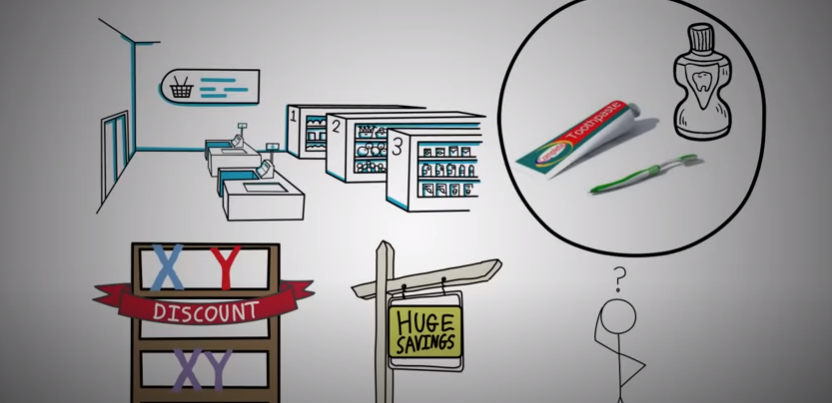
> Have you ever wandered around super market and wondered all the sections and racks are designed in a way that the products are related ? like you can get bread and butter in nearby racks; brush and toothpaste in same racks. These products are associated. If you buy a brush the likelihood of you buying the paste is high. These are marketing tactics to make you fill up the basket with products with their associated items thereby increasing sales revenue. Few business introduce discount in the associated item or combine both the products and sell at a lower rate inorder to make you buy the item+item associated to it 

## What is association rule mining?
> Association rule mining is the technique used to unveil the association between items, where the items we pruchase are denoted as X->Y <br>
>
>Here X is the item we buy and Y is the item we most likely to buy (More like if->then) it is also called as 
>* X- Anticedent 
>* Y- Consequent
>
> Asociation rule mining helps in designing the rules for the assocation of items. These rules are formed with the help of three terminologies

![](https://s3.ap-south-1.amazonaws.com/techleer/243.jpg)
>1.<b>Support:</b> It signifies the popularity of the item, if an item is less frequently bought then it will be ignored in the association. <br>
>
>2.<b>Confidence:</b> It tells the likelihood of purchasing Y when X is bought.Sounds more like a conditional probability.Infact it is ! But it fails to check the popularity(frequency) of Y to overcome that we got lift.<br>
>
>3.<b>Lift:</b> It combines both confidence and support.A lift greater than 1 suggests that the presence of the antecedent increases the chances that the consequent will occur in a given transaction.
Lift below 1 indicates that purchasing the antecedent reduces the chances of purchasing the consequent in the same transaction.
>
>
>For example
> Assume there are 100 customers where 10 of them bought milk, 8 bought butter and 6 bought both of them. We need to check the association of bought milk => bought butter
* support = P(Milk & Butter) = 6/100 = 0.06
* confidence = support/P(Butter) = 0.06/0.08 = 0.75
* lift = confidence/P(Milk) = 0.75/0.10 = 7.5

## What is Apriori?
>Apriori algorithm uses frequent itemsets to get association rules,but on the assumptions that
* All subsets of frequent itemsets must be frequent 
* Similarly incase of infrequent subset their parent set is infrequent too
> The algorithm works in such a way that a minimum support value is set and iterations happen with frequent itemsets. Itemsets and subsets are ignored if their support is below the threshold till there can't be any removal.
>
![](https://imgs.developpaper.com/imgs/158566895-ae3e33380c542b03_articlex.png)
> Later lift of these selected itemsets(rules) are calculated and if the value is below the threshold the rules are eliminated since algorithm may take time to compile if we take all rules

## Preparing the data
> Before proceeding with apriori we have to prepare the data in a sparse matrix format where products are in column and id as index . Initially we group by based on the quantity purchased and later we encode it with 0s and 1s

In [ ]:
#Creating sparse matrix 
basket = (temp.groupby(['id', 'item'])['qty_purchased']
          .sum().unstack().reset_index().fillna(0)
          .set_index('id'))

#Eoding the quantity urchased
def encode(x):
    '''Encoding the quantity of products with 0s and 1s
    0:when qty is less than or equal to 0
    1:when qty is greater than or equal to 1'''
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
#Appying on our data
basket_sets = basket.applymap(encode)
basket_sets

## Applying Apriori
> Here we apply apriori algorithm and get all the frequent itemsets(with 70% as support threshold) and apply association rules function to derive rules where we use lift metric 

In [ ]:
#Apriori- Support70%
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

#Associaton rules-using lift
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.tail()

### Building dynamic function to customize rules

In [ ]:
#Customizable function to change the lift and confidence
def rules_mod(lift,confidence):
    '''rules_mod is a function to control the rules 
    based on lift and confidence threshold'''
    return rules[ (rules['lift'] >= lift) &
      (rules['confidence'] >= confidence) ]

#Calling function
rules_mod(0.7,0.2)

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>
# 7. Visualizing the results
> The results in tabular form will not convey much insights into our algorithm so let's visualize the rules
>
## Relationship between the metrics

In [ ]:
#Setting up the style
plt.figure(figsize = (15, 15))
plt.style.use('seaborn-white')
#Plotting the relationship between the metrics
plt.subplot(221)
sns.scatterplot(x="support", y="confidence",data=rules)
plt.subplot(222)
sns.scatterplot(x="support", y="lift",data=rules)
plt.subplot(223)
sns.scatterplot(x="confidence", y="lift",data=rules)
plt.subplot(224)
sns.scatterplot(x="antecedent support", y="consequent support",data=rules)

><div class="alert alert-info" role="alert">
><ul>
><b>Insights</b> <br>
    <li>Support and confidence has a bleak linear relationship, which means that the most frequent items have some other items associated to it</li> 
    <li>When it come to lift the relationship is squashed in support when it goes beyond 0.10 and in confidence there is no relationship</li> 
    <li>In antecedent and consequent support relationship there is no linear relationship but it's rather inverse ,when conequent support increases the antecedent support fades out -can we consider this phenomenon as when butter quantity of purchase increases the quantity of bread fades?</li>
></ul>
></div>

## Network diagram of rules
> Here we make network diagram of specified number of rules where we can see the antecedents and consequents connected to the rules

In [ ]:
'''a function to build a network diagram connecting antecedents and consequents'''
def draw_graph(rules, rules_to_show):
  import networkx as nx  
  G1 = nx.DiGraph()
   
  color_map=[]
  N = 50
  colors = np.random.rand(N)    
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
   
   
  for i in range (rules_to_show):      
    G1.add_nodes_from(["R"+str(i)])
    
     
    for a in rules.iloc[i]['antecedents']:
                
        G1.add_nodes_from([a])
        
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
    for c in rules.iloc[i]['consequents']:
             
            G1.add_nodes_from([a])
            
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
  for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')       
 
 
   
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]
 
  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
  for p in pos:  # raise text positions
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)
  plt.show()

#Calling function with 10 rules
draw_graph(rules, 10)

><div class="alert alert-info" role="alert">
><ul>
><b>Insights</b> <br>
    <li>It is simpler to visualize with the help of network diagram than seeing in a tabular format</li> 
    <li>The arrow coming to the rules(yellow circle) is from anticedents and the arrows going from rules circle are towards conequents.</li> 
></ul>
></div>

## Strength of association using heatmap
> We have discovered the nassociation of items, what's  good if we don't know the strength of their relationship

In [ ]:
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

><div class="alert alert-info" role="alert">
><ul>
><b>Insights</b> <br>
    <li>We have a strong relationship between yogurt,milk and veggies</li> 
    <li>Roll buns are highly correlated with whole milk.</li> 
></ul>
></div>

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>
# 8. Conclusion

><div class="alert alert-success" role="alert">
><ul>
><li>The model built with <b>Apriori algorithms</b> </li>
><li>It is considered that a apriori algorithm is effective in association rules application and gives constant results everytime</li>
></ul>
>In this analysis, the model wasn't evaluated with any test data, the following viewpoints should be added to the evaluation.
><ul>
><li>Detection of signs of anomalies(rare item)-can help in pushing that item with the associated item</li>
><li>Balance of importance of support and confidence with lift</li>
><li>Model interpretability with visualiations</li>
></ul>
></div>

### My other notebooks can be accessed [here](https://www.kaggle.com/benroshan/notebooks)